# Capsule

In [19]:
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from models import VAE_sigmoid, initialize_weights
from utils import visualize_pixel_distribution, show_8x4_images, plot_training_validation_loss, visualize_reconstruction, plot_and_calculate_losses
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataset import SingleFolderDataset
from train_model import vae_loss, train_vae
from test_model import calculate_losses_for_category, calculate_metrics


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [21]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4070 SUPER , device num:0


In [22]:
train_data_path='data/train/capsule'
val_data_path='data/val/capsule'
test_data_path='data/test/capsule'

In [23]:
image_size=256

learning_rate=0.00005
batch_size=32
input_dim=3
feature_dim=64
latent_dim=512

epochs=500

## Train

In [24]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

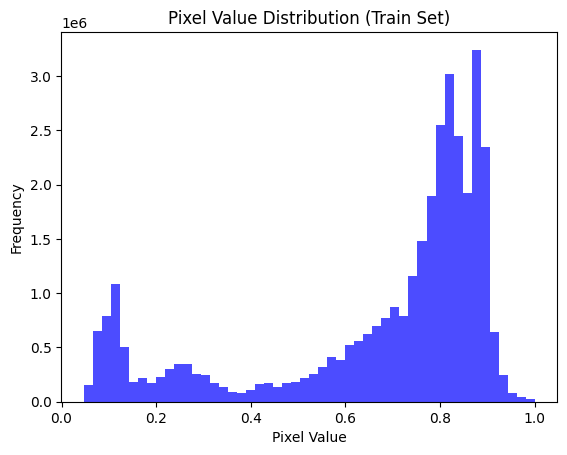

In [25]:
visualize_pixel_distribution(train_loader)

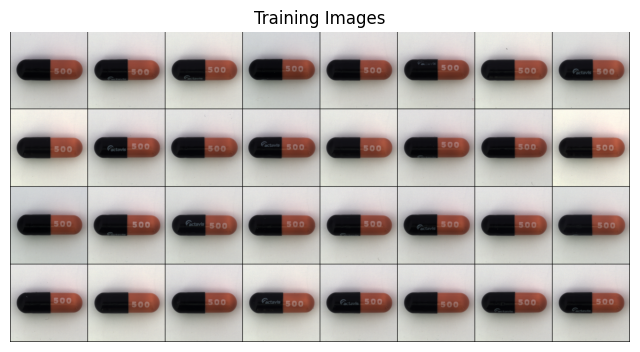

In [26]:
show_8x4_images(train_loader)

In [27]:
model = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 34664.0432, Val Loss: 18133.0270
Epoch [2/500]: Train Loss: 45936.5389, Val Loss: 17325.6978
Epoch [3/500]: Train Loss: 20846.9691, Val Loss: 15828.4631
Epoch [4/500]: Train Loss: 17101.9879, Val Loss: 12506.7965
Epoch [5/500]: Train Loss: 12991.2711, Val Loss: 10006.7956
Epoch [6/500]: Train Loss: 10623.8343, Val Loss: 8328.9863
Epoch [7/500]: Train Loss: 8627.4750, Val Loss: 7113.8583
Epoch [8/500]: Train Loss: 7129.1868, Val Loss: 6123.4029
Epoch [9/500]: Train Loss: 6017.0439, Val Loss: 5301.6695
Epoch [10/500]: Train Loss: 5074.1968, Val Loss: 4547.3549
Epoch [11/500]: Train Loss: 4329.5555, Val Loss: 4000.5721
Epoch [12/500]: Train Loss: 3739.2204, Val Loss: 3504.2140
Epoch [13/500]: Train Loss: 3251.6867, Val Loss: 3103.6910
Epoch [14/500]: Train Loss: 2870.6317, Val Loss: 2761.6842
Epoch [15/500]: Train Loss: 2572.4521, Val Loss: 2501.2508
Epoch [16/500]: Train Loss: 2310.0694, Val Loss: 2254.5534
Epoch [17/500]: Train Loss: 2082.6871, Val Loss: 2040.

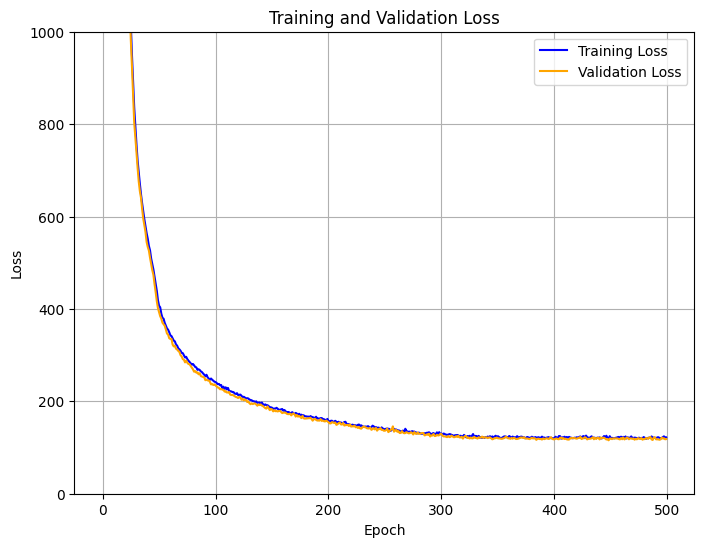

In [29]:
plot_training_validation_loss(train_losses, val_losses, (0, 1000))

In [30]:
torch.save(model.state_dict(), "params/capsule_large_dim.pth")

## Test

In [31]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

inverse_transform = transforms.Compose([
    transforms.ToPILImage()  # 轉回 PIL 圖像
])

In [33]:
model = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
model.load_state_dict(torch.load("params/capsule_large_dim.pth"))

C:\Users\wei\AppData\Local\Temp\ipykernel_16836\2824509429.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("params/capsule_large_dim.pth

<All keys matched successfully>

Error:
loss: 142.79638671875


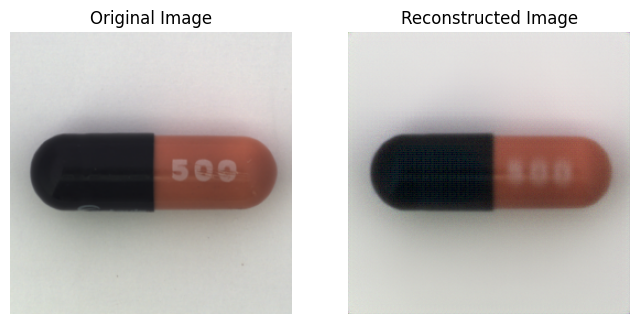

Good:
loss: 92.76006317138672


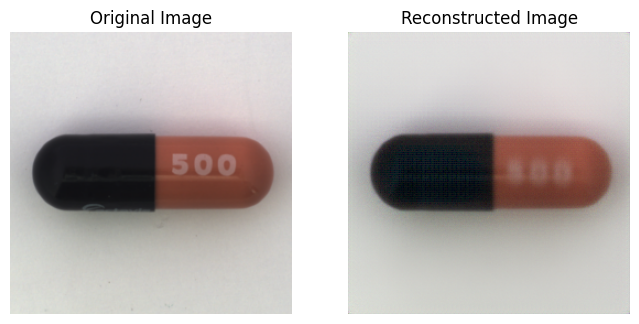

In [34]:
print("Error:")
image_path = "data/test/capsule/error/0.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

print("Good:")
image_path = "data/test/capsule/good/000.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

good avg:  124.84177564538044
defective avg:  193.46966216761038


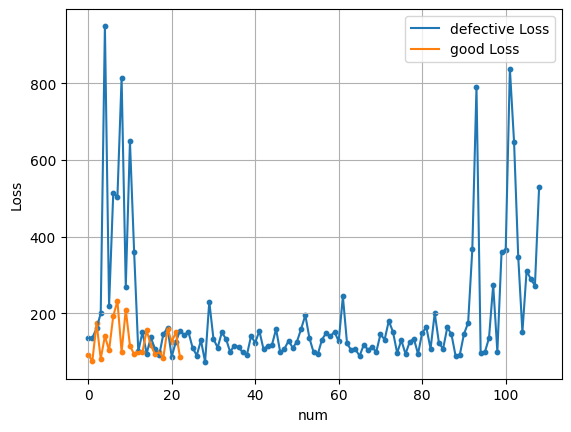

In [38]:
good_losses, error_losses = calculate_losses_for_category(test_data_path, model, vae_loss, transform, device=device)

plot_and_calculate_losses(good_losses, error_losses)

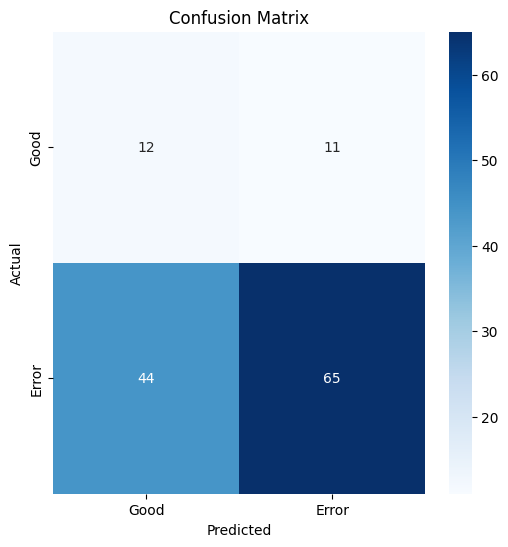

accuracy: 0.5833333333333334, F1 score: 0.7027027027027027


In [39]:
threshold = 120

accuracy, f1_score = calculate_metrics(test_data_path, model, vae_loss, transform, threshold, device=device)
print(f'accuracy: {accuracy}, F1 score: {f1_score}')

In [37]:
torch.cuda.empty_cache()